In [1]:
import os
import torch.nn as nn
import numpy as np
from random import shuffle
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
# from preprocess.focal_loss import FocalLoss
# from utils.svdd_loss import SVDDLoss
from dataloader.svdd_dataloader import CollisionLoader_audio as CollisionLoader_new
from nets.svdd_net_audio import FusionNet_audio_2d as FusionNet
from utils.reconstruction_loss import ReconstructionLoss_audio as ReconstructionLoss
%matplotlib inline
torch.manual_seed(42)
np.random.seed(42)

train_imu = '/home/iot/collision_detect/data/imu/normal_test'
train_audio = '/home/iot/collision_detect/data/audio/normal_test'

test_imu = '/home/iot/collision_detect/data/imu/abnormal/'
test_audio = '/home/iot/collision_detect/data/audio/abnormal/'

checkpoint_path = '/home/iot/collision_detect/output/ours_fusion_1/last_model.pth'

workers = 4
batchsize = 64
dropout_rate = 0.3
kernel_num = 32
feature_dim = 512
num_class = 2
use_attention = 1
Epoch = 200


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
reconstruction_loss_fn = ReconstructionLoss()
loss_function = nn.MSELoss()

train_data = CollisionLoader_new(train_imu,train_audio,train=True,twod=1)
val_data   = CollisionLoader_new(test_imu,test_audio,train=False,twod=1)
train_dataloader = DataLoader(train_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)
val_dataloader   = DataLoader(val_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

random_tensor = torch.load('/home/iot/collision_detect/svdd/center.pth').to(device)
print(random_tensor)
model = FusionNet(use_crossattention=use_attention, feature_dim=feature_dim, dropout_rate=dropout_rate, kernel_num=kernel_num, classes=num_class)
model = model.to(device)

if checkpoint_path != '':
    model.load_state_dict(torch.load(checkpoint_path))
    print('Load weights')


cuda
tensor([-6.4254e-01,  5.5300e-01,  1.2240e-01, -2.2295e+00, -5.7496e-01,
         3.5828e-01,  7.7276e-01,  7.2333e-01, -2.8258e+00, -1.1255e+00,
        -7.0408e-01, -9.8366e-01, -1.5737e+00, -8.2207e-01, -1.3945e+00,
         1.7322e-01, -7.5201e-01, -1.3309e+00, -4.4025e-01, -1.7162e+00,
         1.0407e+00,  1.3234e+00,  4.2049e-01,  6.6767e-01,  5.9250e-01,
         4.5115e-01, -1.8596e-01, -2.0435e+00,  1.2532e+00, -8.9810e-01,
        -3.8417e-01,  5.2701e-01,  7.2706e-01, -2.3640e-01,  4.0849e-01,
         1.5841e+00, -2.5519e-01,  1.6615e+00,  6.9533e-01, -1.2333e+00,
         1.6704e+00,  1.3261e+00,  6.4490e-01, -1.3971e+00, -1.1881e+00,
        -1.3949e+00,  1.0209e+00, -1.0489e+00, -1.8577e+00, -1.5231e+00,
         1.1296e+00,  7.3071e-01,  1.0346e-01, -1.0610e+00, -1.2641e+00,
        -4.6478e-01, -1.4280e+00, -1.0170e+00, -9.5685e-01,  1.1770e-01,
        -9.0485e-01,  3.2928e-01,  3.4353e-01, -4.9571e-01,  2.3721e+00,
         1.3229e-01, -7.3896e-01, -8.0108e-02,

/home/iot/anaconda3/envs/ai/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Reconstruction Loss 0.0000
SVDd Loss for Sample: 0.0003


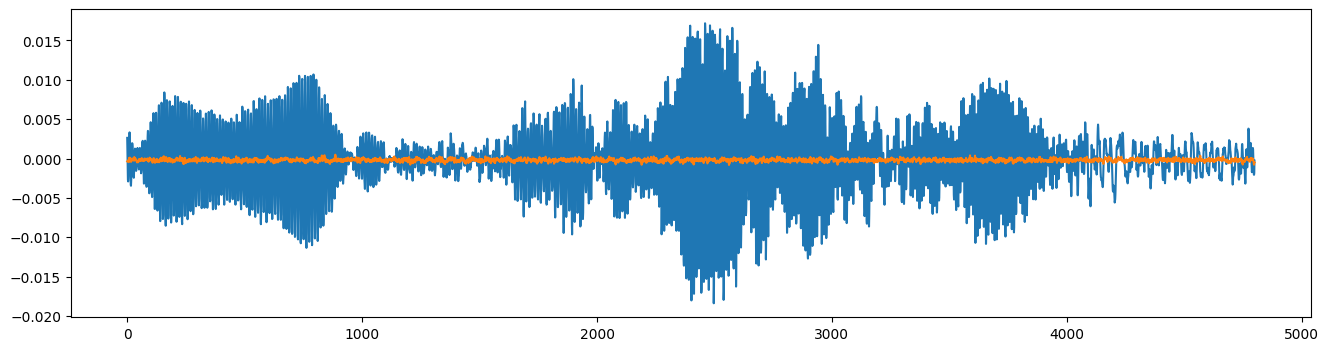

In [2]:
model.eval()
sample_idx = 109
# Change thisto the index of the sample you want to load
spec, imu, audio = train_data[sample_idx]

spec, imu, audio = spec.to(device), imu.to(device), audio.to(device)
audio,imu = audio.unsqueeze(0),imu.unsqueeze(0)

anomaly_score, reconstructed_audio = model(audio, imu)

target_zero = random_tensor.unsqueeze(0).expand(1, -1)
svdd_loss = loss_function(anomaly_score, target_zero)*10
reconstruction_loss = reconstruction_loss_fn(audio.view(1,-1), reconstructed_audio)

total_loss = svdd_loss+reconstruction_loss

print(f"Reconstruction Loss {reconstruction_loss.item():.4f}")
print(f"SVDd Loss for Sample: {svdd_loss.item():.4f}")
plt.figure(figsize=(16, 4))
plt.plot(audio.view(1,-1).cpu().numpy().squeeze(), label='Original Audio')
plt.plot(reconstructed_audio.cpu().detach().numpy().squeeze(0), label='Reconstructed Audio')
# plt.legend()


In [3]:
audio.cpu().detach().numpy().squeeze(0).shape

(48, 100)

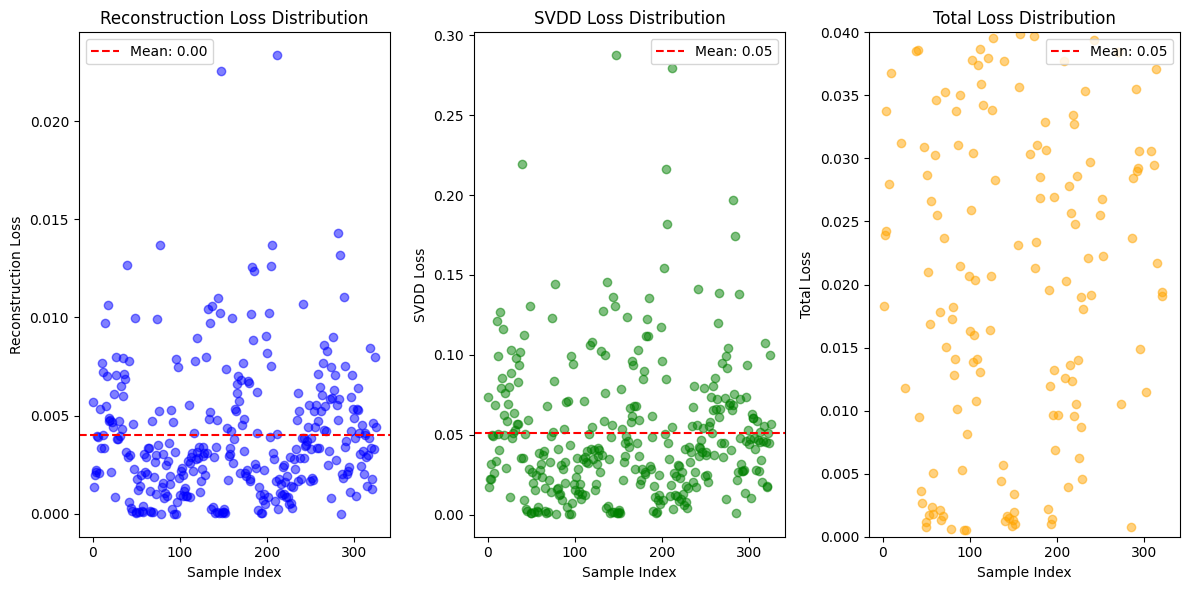

In [4]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses_val = []
svdd_losses_val = []
total_losses_val = []
total_sample = 0
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, image, audio = val_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        # audio,image = audio.unsqueeze(0),image.unsqueeze(0)
    # Forward pass through the model
        anomaly_score, reconstructed_audio = model(audio, audio)

        # Calculate reconstruction loss for the sample
        reconstruction_loss = reconstruction_loss_fn( audio.view(1,-1), reconstructed_audio) * 10

        # Generate random tensor for SVDD loss
        target_zero = random_tensor.unsqueeze(0).expand(audio.size(0), -1)

        # Calculate SVDD loss for the sample
        svdd_loss = loss_function(anomaly_score, target_zero)*100

        # Calculate total loss for the sample
        total_loss = svdd_loss + reconstruction_loss

        # Append individual loss values to the lists
        reconstruction_losses_val.append(reconstruction_loss.item())
        svdd_losses_val.append(svdd_loss.item())
        total_losses_val.append(total_loss.item())
        total_sample+=1

# Plotting the data distribution of losses using scatter plots
mean_reconstruction_loss = sum(reconstruction_losses_val) / len(reconstruction_losses_val)
mean_svdd_loss = sum(svdd_losses_val) / len(svdd_losses_val)
mean_total_loss = sum(total_losses_val) / len(total_losses_val)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(total_sample), reconstruction_losses_val, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(min(reconstruction_losses), 0.8)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(total_sample), svdd_losses_val, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
# plt.ylim(min(svdd_losses_val), 0.04)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(total_sample), total_losses_val, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
plt.ylim(0,0.04)
plt.legend()

plt.tight_layout()
plt.show()

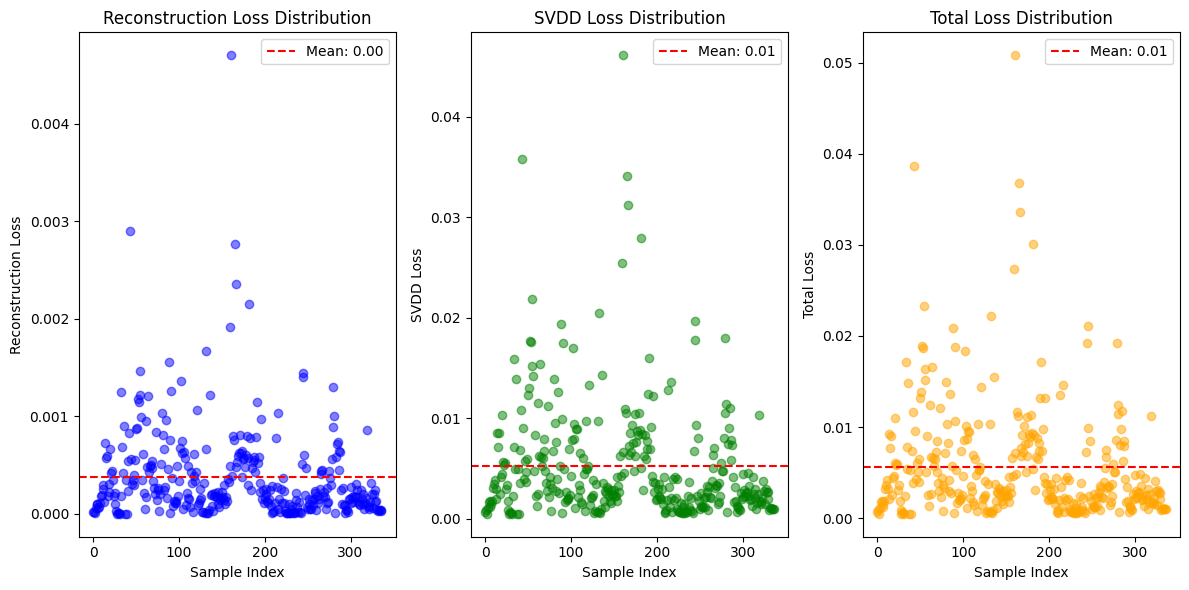

In [5]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses_train = []
svdd_losses_train = []
total_losses_train = []

# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(train_data)):
        spec, image, audio = train_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        # audio,image = audio.unsqueeze(0),image.unsqueeze(0)
        # Forward pass through the model
        anomaly_score, reconstructed_audio = model(audio, audio)

        # Calculate reconstruction loss for the sample
        reconstruction_loss = reconstruction_loss_fn(audio.view(1,-1), reconstructed_audio) * 10

        # Generate random tensor for SVDD loss
        target_zero = random_tensor.unsqueeze(0).expand(audio.size(0), -1)

        # Calculate SVDD loss for the sample0
        svdd_loss = loss_function(anomaly_score, target_zero)*100

        # Calculate total loss for the sample
        total_loss = svdd_loss + reconstruction_loss

        # Append individual loss values to the lists
        reconstruction_losses_train.append(reconstruction_loss.item())
        svdd_losses_train.append(svdd_loss.item())
        total_losses_train.append(total_loss.item())

# Plotting the data distribution of losses using scatter plots
mean_reconstruction_loss = sum(reconstruction_losses_train) / len(reconstruction_losses_train)
mean_svdd_loss = sum(svdd_losses_train) / len(svdd_losses_train)
mean_total_loss = sum(total_losses_train) / len(total_losses_train)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(len(train_data)), reconstruction_losses_train, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(min(reconstruction_losses), max(reconstruction_losses)*1.1)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(len(train_data)), svdd_losses_train, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
# plt.ylim(min(svdd_losses), max(svdd_losses)*1.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(train_data)), total_losses_train, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
# plt.ylim(min(total_losses), max(total_losses)*1.1)
plt.legend()

plt.tight_layout()
plt.show()

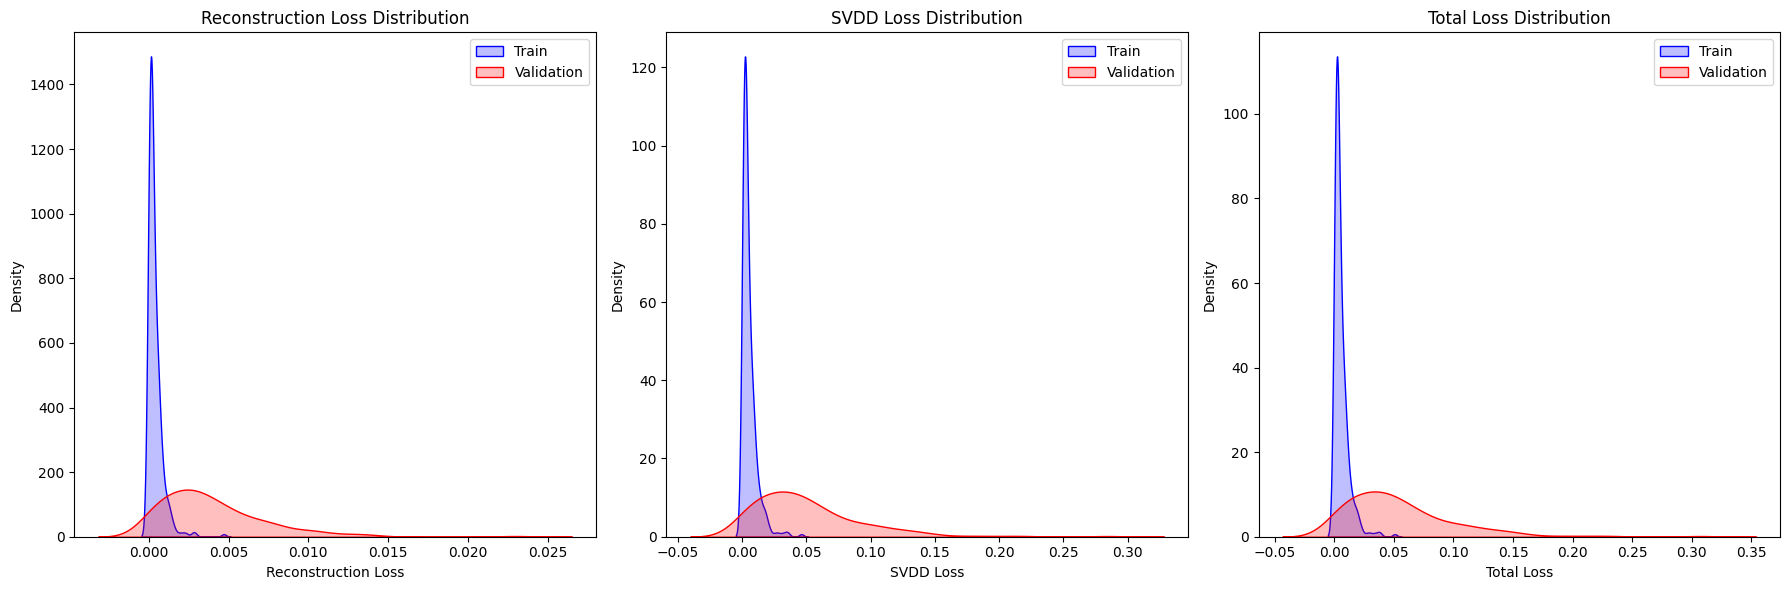

In [6]:
import seaborn as sns

# Plotting KDE plots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(reconstruction_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(reconstruction_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.title('Reconstruction Loss Distribution')
plt.legend()

plt.subplot(1, 3, 2)
sns.kdeplot(svdd_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(svdd_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
# plt.ylim(0, 1)
# plt.xlim(0, 40)
plt.legend()

plt.subplot(1, 3, 3)
sns.kdeplot(total_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(total_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss Distribution')
plt.legend()

plt.tight_layout()
plt.show()


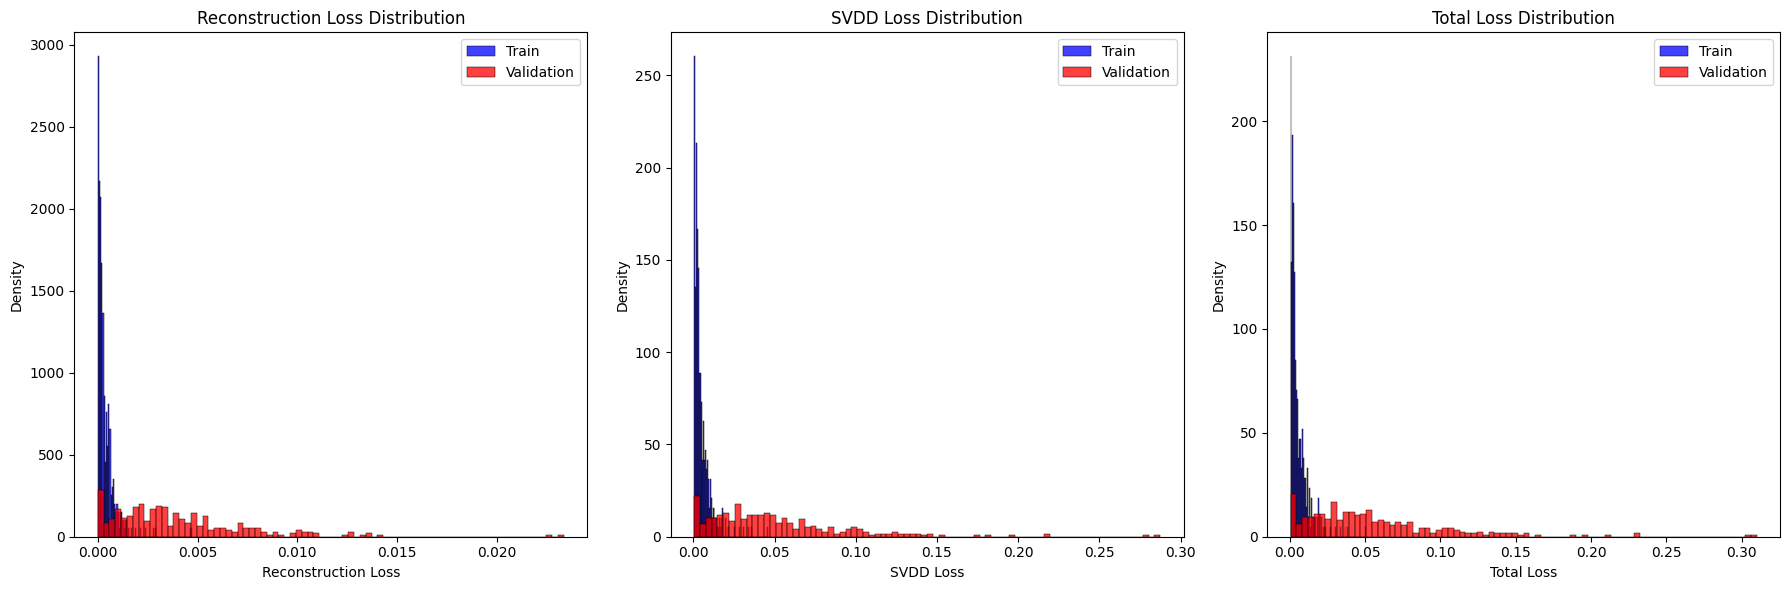

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting histograms
plt.figure(figsize=(18, 6))

# Plot for Reconstruction Loss Distribution
plt.subplot(1, 3, 1)
sns.histplot(reconstruction_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(reconstruction_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.title('Reconstruction Loss Distribution')
plt.legend()

# Plot for SVDD Loss Distribution
plt.subplot(1, 3, 2)
sns.histplot(svdd_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(svdd_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
# plt.ylim(0, 1)
# plt.xlim(0, 0.4)
plt.legend()

# Plot for Total Loss Distribution
plt.subplot(1, 3, 3)
sns.histplot(total_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(total_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss Distribution')

plt.legend()

plt.tight_layout()
plt.show()


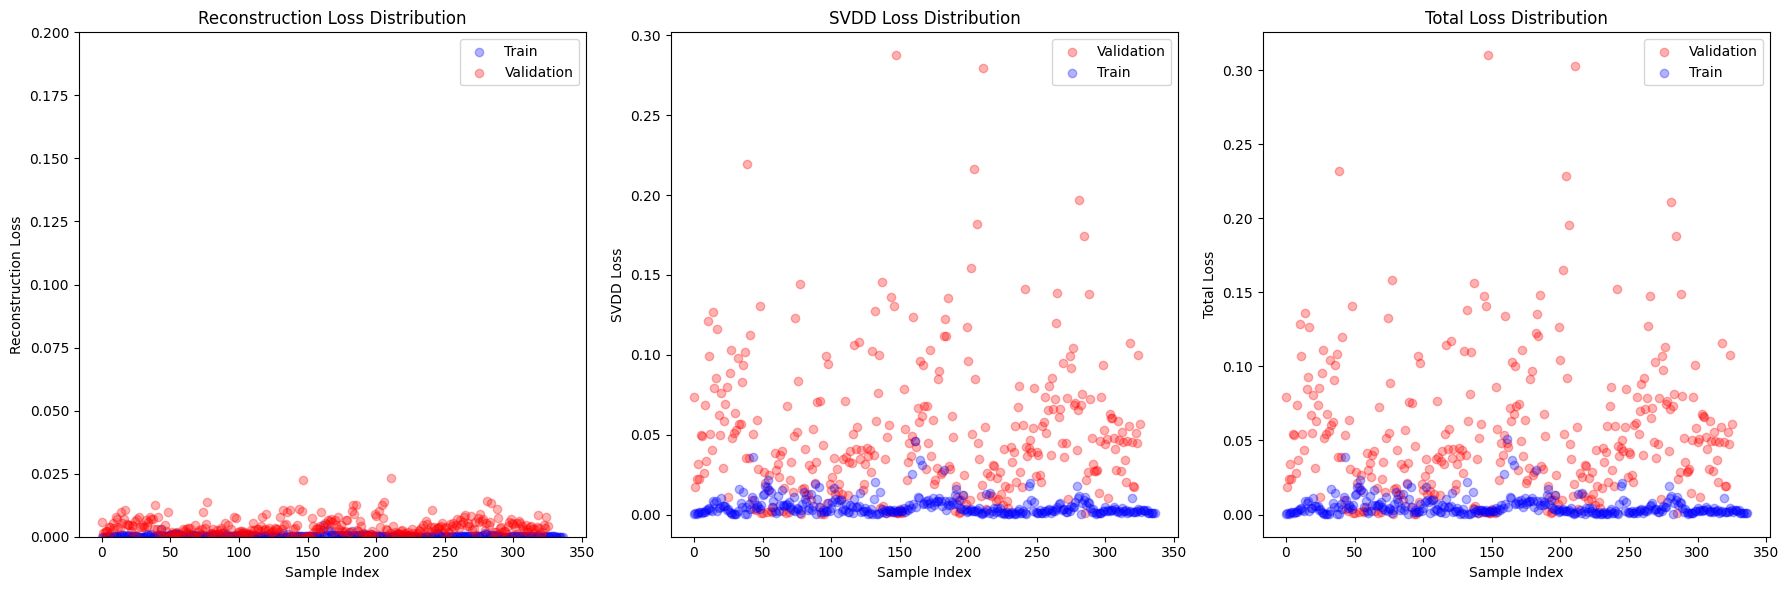

In [8]:
import matplotlib.pyplot as plt

# Plotting scatter plots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(len(reconstruction_losses_train)), reconstruction_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(reconstruction_losses_val)), reconstruction_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.ylim(0,0.2)
plt.title('Reconstruction Loss Distribution')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(len(svdd_losses_val)), svdd_losses_val, color='red', alpha=0.3, label='Validation')
plt.scatter(range(len(svdd_losses_train)), svdd_losses_train, color='blue', alpha=0.3, label='Train')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
# plt.ylim(0,0.5)
plt.title('SVDD Loss Distribution')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(total_losses_val)), total_losses_val, color='red', alpha=0.3, label='Validation')
plt.scatter(range(len(total_losses_train)), total_losses_train, color='blue', alpha=0.3, label='Train')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
def z_score_normalization(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = [(x - mean) / std_dev for x in data]
    return normalized_data


loss_all_audio = svdd_losses_train+svdd_losses_val
loss_all_audio = np.array(loss_all_audio)
loss_all_audio = z_score_normalization(loss_all_audio)


loss_all_recons = reconstruction_losses_train+reconstruction_losses_val
loss_all_recons = np.array(loss_all_recons)
loss_all_recons = z_score_normalization(loss_all_recons)

In [10]:
labels_all = np.concatenate([np.zeros(len(svdd_losses_train)),np.ones(len(svdd_losses_val))])
loss_all = [x + y for x, y in zip(loss_all_audio, loss_all_recons)]

In [11]:
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 

In [12]:
eval_metrics = ts_metrics(labels_all, (loss_all))

In [13]:
eval_metrics

(0.9166954907065228,
 0.9413323476867078,
 0.878043780702176,
 0.8727272727272727,
 0.8834355828220859)

In [1]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, ff_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim)

        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        decoder_layers = nn.TransformerDecoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layers, num_layers=num_layers)

        self.output_layer = nn.Linear(model_dim, input_dim)
        self.inter_layer = nn.Linear(2048, 512)
    
    def forward(self, src, tgt):
        src = self.embedding(src) * torch.sqrt(torch.tensor(self.model_dim, dtype=torch.float32))
        src = self.positional_encoding(src)

        tgt = self.embedding(tgt) * torch.sqrt(torch.tensor(self.model_dim, dtype=torch.float32))
        tgt = self.positional_encoding(tgt)

        memory = self.encoder(src)
        mem_out = memory.view(-1,4*512)
        mem_out = self.inter_layer(mem_out)
        
        output = self.decoder(tgt, memory)
        output = self.output_layer(output)
        return mem_out,output

# Example usage
input_dim = 4800
model_dim = 512
num_heads = 8
num_layers = 6
ff_dim = 2048

model = TransformerModel(input_dim, model_dim, num_heads, num_layers, ff_dim)

# # Dummy data
# batch_size = 16
# src = torch.rand(batch_size, 4, 4800)  # (batch_size, 4, 4800)
# tgt = torch.rand(batch_size, 4, 4800)  # (batch_size, 4, 4800)

# # # Reshape to (4, batch_size, 4800)
# # src = src.permute(1, 0, 2)
# # tgt = tgt.permute(1, 0, 2)

# mem,output = model(src, tgt)

# # # Reshape output back to (batch_size, 4, 4800)
# # mem = mem.permute(1, 0, 2)
# # output = output.permute(1, 0, 2)
# print(output.shape,mem.shape)  # Should be (4, 4, 4800)


/home/iot/anaconda3/envs/ai/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [2]:
import os
import torch.nn as nn
import numpy as np
from random import shuffle
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
from dataloader.svdd_dataloader import CollisionLoader_audio as CollisionLoader_new
from nets.svdd_net_audio import FusionNet_audio_2d as FusionNet
from utils.reconstruction_loss import ReconstructionLoss_audio,CompactFeatureLoss
from utils.svdd_loss import DSVDDLoss
from sklearn import svm
import joblib
torch.manual_seed(42)
np.random.seed(42)


train_audio_path = '/home/iot/collision_detect/data/audio/normal_train'
train_imu_path = '/home/iot/collision_detect/data/imu/normal_train'

test_audio_path = '/home/iot/collision_detect/data/audio/abnormal'
test_imu_path = '/home/iot/collision_detect/data/imu/abnormal'

checkpoint_path = ''
save_path = '/home/iot/collision_detect/output'

workers = 4
batchsize = 32
dropout_rate = 0.3
kernel_num = 32
feature_dim = 512
num_class = 2
use_attention = 1
Epoch = 300
save_name = "ours_audio_svdd_{}".format(use_attention)
save_dir = os.path.join(save_path, save_name)
os.makedirs(save_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
svdd_losses = []
reconstruction_losses = []
train_data = CollisionLoader_new(train_imu_path,train_audio_path,augment = False)
val_data   = CollisionLoader_new(test_imu_path,test_audio_path,augment = False)

audio = val_data.audio_list
imu  = val_data.imu_list

train_dataloader = DataLoader(train_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)
val_dataloader   = DataLoader(val_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)


model = model.to(device)

if checkpoint_path != '':
    model.load_state_dict(torch.load(checkpoint_path))

optimizer  = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler  = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
reconstruction_loss_fn = ReconstructionLoss_audio()
feature_loss = CompactFeatureLoss()
loss_function = nn.MSELoss()

random_tensor = torch.load('/home/iot/collision_detect/svdd/center.pth').to(device)
best_val_loss = float('inf')
best_model_state_dict = None

# torch.save(random_tensor, '/home/iot/collision_detect/svdd/center.pth')
print(random_tensor)

target_zero = random_tensor.unsqueeze(0).expand(batchsize, -1)
Dsvdd = DSVDDLoss(target_zero)

for epoch in range(Epoch):
    model.train()
    total_train_loss = 0
    total_svdd_loss = 0
    total_reconstruction_loss = 0

    for i, data in enumerate(train_dataloader, 0):
        spec, imu, audio = data
        spec, imu, audio = spec.to(device), imu.to(device), audio.to(device)
        optimizer.zero_grad()
        anomaly_score, reconstructed_audio = model(audio, spec)
        all_feature_loss = feature_loss(anomaly_score)

        
        # svdd_loss = loss_function(anomaly_score, target_zero)*10
        svdd_loss = Dsvdd(anomaly_score)
        total_svdd_loss += svdd_loss.item()
        svdd_losses.append(svdd_loss.item())
        
        reconstruction_loss = reconstruction_loss_fn(spec, reconstructed_audio)*10000
        total_reconstruction_loss += reconstruction_loss.item()
        reconstruction_losses.append(reconstruction_loss.item())

        total_loss = reconstruction_loss+svdd_loss
        total_loss.backward()
        optimizer.step()

        total_train_loss += total_loss.item()

    mean_train_loss = total_train_loss / len(train_dataloader)
    mean_svdd_loss = total_svdd_loss / len(train_dataloader)
    mean_reconstruction_loss = total_reconstruction_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{Epoch}], Train Loss: {mean_train_loss:.4f}, SVDD Loss: {mean_svdd_loss:.4f}, Reconstruction Loss: {mean_reconstruction_loss:.4f}, feature Loss: {all_feature_loss:.4f}")

    if (epoch + 1) % 1 == 0:
        model.eval()
        total_val_loss = 0
        total_val_svdd_loss = 0
        total_val_reconstruction_loss = 0

        with torch.no_grad():
            for i, data in enumerate(val_dataloader, 0):
                spec, imu, audio = data
                spec, imu, audio = spec.to(device), imu.to(device), audio.to(device)
                anomaly_score, reconstructed_audio = model(audio, audio)

                all_feature_loss = feature_loss(anomaly_score)
                target_zero = random_tensor.unsqueeze(0).expand(batchsize, -1)
                # svdd_loss = loss_function(anomaly_score, target_zero)*10
                svdd_loss = Dsvdd(anomaly_score)
                total_val_svdd_loss += svdd_loss.item()

                reconstruction_loss = reconstruction_loss_fn(spec, reconstructed_audio)*10000
                total_val_reconstruction_loss += reconstruction_loss.item()
    
                total_loss = reconstruction_loss+svdd_loss
                total_val_loss += total_loss.item()

        mean_val_loss = total_val_loss / len(val_dataloader)
        mean_val_svdd_loss = total_val_svdd_loss / len(val_dataloader)
        mean_val_reconstruction_loss = total_val_reconstruction_loss / len(val_dataloader)

    print(f"\033[94mEpoch [{epoch+1}/{Epoch}], Val Loss: {mean_val_loss:.4f}, Val SVDD Loss: {mean_val_svdd_loss:.4f}, Val Reconstruction Loss: {mean_val_reconstruction_loss:.4f}, feature Loss: {all_feature_loss:.4f}\033[0m")
    
    # torch.save(model.state_dict(), os.path.join(save_dir,str(epoch)+'_'+str(total_val_loss-total_train_loss)))

    torch.save(model.state_dict(), os.path.join(save_dir,'last_model.pth'))

cuda


FileNotFoundError: [Errno 2] No such file or directory: '/home/iot/collision_detect/svdd/center.pth'

Reconstruction Loss 0.0001
SVDd Loss for Sample: 0.0286


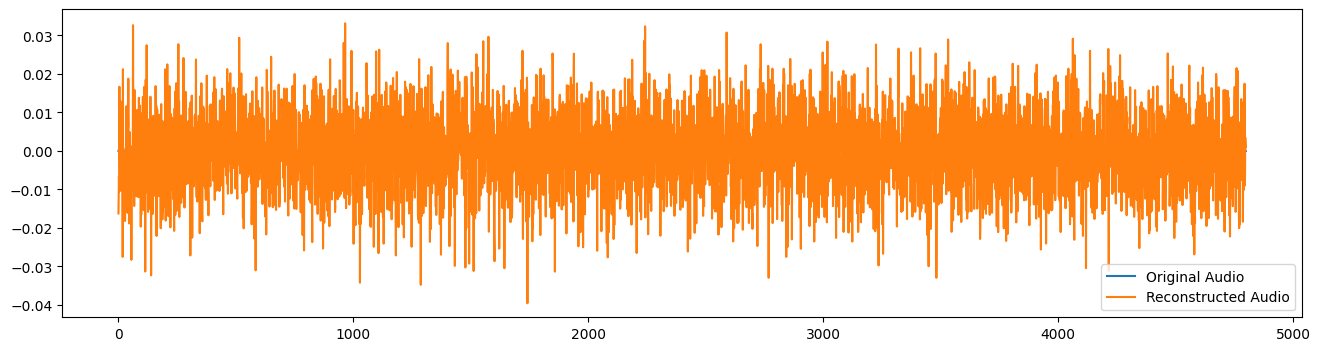

In [112]:
model.eval()
sample_idx = 0 
# Change this to the index of the sample you want to load
spec, imu, audio = train_data[sample_idx]

spec, imu, audio = spec.to(device), imu.to(device), audio.to(device)
audio,imu = audio.unsqueeze(0),imu.unsqueeze(0)

anomaly_score, reconstructed_audio = model(audio, spec)

target_zero = random_tensor.unsqueeze(0).expand(1, -1)
svdd_loss = loss_function(anomaly_score, target_zero)*10
reconstruction_loss = reconstruction_loss_fn(spec.unsqueeze(0), reconstructed_audio)

total_loss = svdd_loss+reconstruction_loss

print(f"Reconstruction Loss {reconstruction_loss.item():.4f}")
print(f"SVDd Loss for Sample: {svdd_loss.item():.4f}")
plt.figure(figsize=(16, 4))
plt.plot(spec.cpu().numpy().squeeze()[0], label='Original Audio')
plt.plot(reconstructed_audio.cpu().detach().numpy().squeeze(0)[0], label='Reconstructed Audio')
plt.legend()


In [51]:
import torch
import numpy as np
from torch.nn.utils import weight_norm
from deepod.core.networks.ts_network_transformer import TSTransformerEncoder
from deepod.core.networks.ts_network_dilated_conv import DilatedConvEncoder
from deepod.core.networks.ts_network_tcn import TCNnet, TcnAE
# from deepod.core.base_transformer_network_dev import TSTransformerEncoder
from deepod.core.networks.network_utility import _instantiate_class, _handle_n_hidden
import torch.nn.modules.activation


class ConvSeqEncoder(torch.nn.Module):
    """
    this network architecture is from NeurTraL-AD
    """
    def __init__(self, n_features, n_hidden='100', n_output=128, n_layers=3, seq_len=100,
                 bias=True, batch_norm=True, activation='ReLU'):
        super(ConvSeqEncoder, self).__init__()

        n_hidden, _ = _handle_n_hidden(n_hidden)

        self.bias = bias
        self.batch_norm = batch_norm
        self.activation = activation

        enc = [self._make_layer(n_features, n_hidden, (3,1,1))]
        in_dim = n_hidden
        window_size = seq_len
        for i in range(n_layers - 2):
            out_dim = n_hidden*2**i
            enc.append(self._make_layer(in_dim, out_dim, (3,2,1)))
            in_dim =out_dim
            window_size = np.floor((window_size+2-3)/2)+1

        self.enc = torch.nn.Sequential(*enc)
        self.final_layer = torch.nn.Conv1d(in_dim, n_output, int(window_size), 1, 0)

    def _make_layer(self, in_dim, out_dim, conv_param):
        down_sample = None
        if conv_param is not None:
            down_sample = torch.nn.Conv1d(in_channels=in_dim, out_channels=out_dim,
                                          kernel_size=conv_param[0], stride=conv_param[1], padding=conv_param[2],
                                          bias=self.bias)
        elif in_dim != out_dim:
            down_sample = torch.nn.Conv1d(in_channels=in_dim, out_channels=out_dim,
                                          kernel_size=1, stride=1, padding=0,
                                          bias=self.bias)

        layer = ConvResBlock(in_dim, out_dim, conv_param, down_sample=down_sample,
                             batch_norm=self.batch_norm, bias=self.bias, activation=self.activation)

        return layer

    def forward(self, x):
        x = x.permute(0, 2, 1)
        z = self.enc(x)
        # z = self.final_layer(z)
        return z.squeeze(-1)


class ConvResBlock(torch.nn.Module):
    """Convolutional Residual Block"""
    def __init__(self, in_dim, out_dim, conv_param=None, down_sample=None,
                 batch_norm=False, bias=False, activation='ReLU'):
        super(ConvResBlock, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_dim, in_dim,
                                     kernel_size=1, stride=1, padding=0, bias=bias)

        if conv_param is not None:
            self.conv2 = torch.nn.Conv1d(in_dim, in_dim,
                                         conv_param[0], conv_param[1], conv_param[2],bias=bias)
        else:
            self.conv2 = torch.nn.Conv1d(in_dim, in_dim,
                                         kernel_size=3, stride=1, padding=1, bias=bias)

        self.conv3 = torch.nn.Conv1d(in_dim, out_dim,
                                     kernel_size=1, stride=1, padding=0, bias=bias)

        if batch_norm:
            self.bn1 = torch.nn.BatchNorm1d(in_dim)
            self.bn2 = torch.nn.BatchNorm1d(in_dim)
            self.bn3 = torch.nn.BatchNorm1d(out_dim)
            if down_sample:
                self.bn4 = torch.nn.BatchNorm1d(out_dim)

        self.act = _instantiate_class("torch.nn.modules.activation", activation)
        self.down_sample = down_sample
        self.batch_norm = batch_norm

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        if self.batch_norm:
            out = self.bn1(out)
        out = self.act(out)

        out = self.conv2(out)
        if self.batch_norm:
            out = self.bn2(out)
        out = self.act(out)

        out = self.conv3(out)
        if self.batch_norm:
            out = self.bn3(out)

        if self.down_sample is not None:
            residual = self.down_sample(x)
            if self.batch_norm:
                residual = self.bn4(residual)

        out += residual
        out = self.act(out)

        return out


if __name__ == '__main__':
    model = ConvSeqEncoder(n_features=4, n_hidden='64', n_layers=4, seq_len=4800, batch_norm=False,
                           n_output=1, activation='LeakyReLU')
    print(model)
    a = torch.randn(32, 4800, 4)

    b =  model(a)
    print(b.shape)

ConvSeqEncoder(
  (enc): Sequential(
    (0): ConvResBlock(
      (conv1): Conv1d(4, 4, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv3): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
      (act): LeakyReLU(negative_slope=0.01)
      (down_sample): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (1): ConvResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (act): LeakyReLU(negative_slope=0.01)
      (down_sample): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    )
    (2): ConvResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (conv3): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (act): LeakyReLU(negative_slope=0.01)
  

In [52]:
from torchsummary import summary
summary(model.to('cuda'), input_size=(4800,4 ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 4800]              20
         LeakyReLU-2              [-1, 4, 4800]               0
            Conv1d-3              [-1, 4, 4800]              52
         LeakyReLU-4              [-1, 4, 4800]               0
            Conv1d-5             [-1, 64, 4800]             320
            Conv1d-6             [-1, 64, 4800]             832
         LeakyReLU-7             [-1, 64, 4800]               0
      ConvResBlock-8             [-1, 64, 4800]               0
            Conv1d-9             [-1, 64, 4800]           4,160
        LeakyReLU-10             [-1, 64, 4800]               0
           Conv1d-11             [-1, 64, 2400]          12,352
        LeakyReLU-12             [-1, 64, 2400]               0
           Conv1d-13             [-1, 64, 2400]           4,160
           Conv1d-14             [-1, 6

In [11]:

def downsample(audio, old_sample_rate=48000, new_sample_rate=4800):
    """
    Downsample audio from old_sample_rate to new_sample_rate.
    """
    ratio = old_sample_rate // new_sample_rate
    downsampled_audio = audio[:, ::ratio]
    return downsampled_audio

In [21]:
audio = np.load('/home/iot/collision_detect/data/audio/abnormal/box_a/seq0001.npy')

In [22]:
audio      = downsample(audio)
audio      = np.mean(audio,axis=0)

In [23]:
def get_sub_seqs(x_arr, seq_len=100, stride=1):
    """

    Parameters
    ----------
    x_arr: np.array, required
        input original data with shape [time_length, channels]

    seq_len: int, optional (default=100)
        Size of window used to create subsequences from the data

    stride: int, optional (default=1)
        number of time points the window will move between two subsequences

    Returns
    -------
    x_seqs: np.array
        Split sub-sequences of input time-series data
    """

    if x_arr.shape[0] < seq_len:
        seq_len = x_arr.shape[0]
    seq_starts = np.arange(0, x_arr.shape[0] - seq_len + 1, stride)
    x_seqs = np.array([x_arr[i:i + seq_len] for i in seq_starts])

    return x_seqs

In [24]:
audio = get_sub_seqs(audio,100,100)

In [25]:
audio.shape

(48, 100)